<a href="https://colab.research.google.com/github/valmeau/w07-final-project/blob/master/bvh_exploratory_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 - Forest Cover Type Prediction

## Final Project Baseline

## Team:
- Brittney Van Hese
- Prabhaker Narsina
- Valérie Méausoone


###Envoirnment Set-Up

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier
from  sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### **Exploratory Data Analysis**
We perform an EDA on the training dataset provided by the Kaggle competition.

#### Importing the Data

To begin, we import that training data set that is provided for us as a part of the problem. Then we display the columns found in our data set, along with a preview of the data contained within.

In [4]:
train_df = pd.read_csv('/content/train.csv', index_col='Id')
col_names = train_df.columns.tolist()

print("Column names:")
print(col_names)

print("\nSample data:")
train_df.head()

Column names:
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

Sample data:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


From the problem prompt, the objective is to predict the Cover Type, or tree coverage species, to be expected in an area given the descriptive features of the area like: Elevation, shade levels, and distance to nearby water and roads. Therefore, we will separate out the target class to be predicted and count the remaining features and the total number of observations they describe. 

In [5]:
# Isolate target data
cover_type = train_df['Cover_Type']
y = np.array(cover_type)

# Dropping output from feature space
to_drop = ['Cover_Type']
cover_feat_space = train_df.drop(to_drop, axis = 1)

# Pull out geatures for future use
features = cover_feat_space.columns
X = np.array(cover_feat_space).astype(np.float)

print("Feature space hold %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))

Feature space hold 15120 observations and 54 features
Unique target labels: [1 2 3 4 5 6 7]


#### Assessing Data Quality

Before attempting any predictions, it is important we check the training data that will be passed to any models. Here we check of any missing or erroneous values. 

In [6]:
# Assessing missingness
print("There are", np.count_nonzero(np.isnan(X)), "missing values among our features")
print("There are", np.count_nonzero(np.isnan(y)), "missing values among our target values")

#Assessing plausibility of values
print("\nLooking at summary statistics for our training data:")
train_df.describe()

There are 0 missing values among our features
There are 0 missing values among our target values

Looking at summary statistics for our training data:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.00000

The variables all have plausible distributions. We notice a negative minimum for "Vertical_Distance_To_Hydrology" but understand that it is a plausible minimum value, as the surface of the nearest water source for areas - such as mountainous regions - will be beneath the area being evaluated. 

Therefore, we conclude there are no obvious issues with the data set and proceed with exploration of the features.



#### Feature Exploration

First, we ensure that each target class is represented fairly in the data set. 

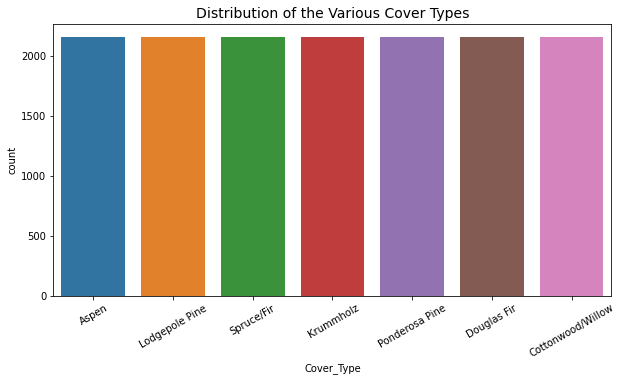

In [7]:
#Plotting the target
#Renaming the target labels to make them more meaningful
train_df['Cover_Type'].replace({1:'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas Fir', 7: ' Krummholz'}, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Distribution of the Various Cover Types", size = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax = sns.countplot(x = "Cover_Type", data = train_df)

From the figure above, it is clear that each target class is equally represented in the data set. Next, we see if any of the features offer distinctions between our Cover Types; starting with our categorical features. 

In [9]:
#Plotting catgorical features
#Transform binary into a few categorical variables, and giving them more meaningful names where possible
train_df = train_df.rename(columns={"Wilderness_Area1":"Rawah_WA","Wilderness_Area2":"Neota_WA",
"Wilderness_Area3":"Comanche_Peak_WA","Wilderness_Area4":"Cache_la_Poudre_WA"})
train_df['Wilderness_Areas'] = (train_df.iloc[:,10:14] == 1).idxmax(1)

fig = px.histogram(train_df, x="Wilderness_Areas", color="Cover_Type", barmode="group", title='Distribution of Wildreness Area by Cover Type')
fig.show()

In [10]:
train_df['Soil_Type'] = (train_df.iloc[:,15:55] == 1).idxmax(1)
fig = px.histogram(train_df, x="Soil_Type", color="Cover_Type", title='Distribution of the Soil Types by Cover Types')
fig.show()

Each of our categorical feature values appear to provide separation between our target classes. Next let us look at the distributions of our numerical features.

In [ ]:
#Plotting and grouping numerical features according to target classes
plt.figure(figsize=(16, 8))

num_values_range = 10
# Iterate over the features, creating a subplot with a histogram for each one.
for feature in range(num_values_range):
    fig1, ax1 = plt.subplots()
    ax1.set_title(train_df.columns[feature], size = 14)
    ax1 = sns.boxplot(x = train_df.columns[feature], y = 'Cover_Type' , data = train_df)

From all the above plots, we do see some separation between features and classes, but we also see significant overlap of the numerical feature distributions. This could cause problems for our predictions depending on the model we select.

#### Feature Covariance Matrix

The last feature evaluation step we will take is an look at feature covariance. 

In [11]:
label_classes = classes=[1, 2, 3,4,5,6,7]
y_binarized = label_binarize(y, label_classes)
outcome_df = pd.DataFrame(y_binarized, columns = ['Spruce_Fir','Lodgepole_Pine','Ponderosa Pine','Cottonwood_Willow', 'Aspen','Douglas Fir','Krummholz'])
corr_data = pd.concat([train_df.iloc[:,0:54], outcome_df], axis=1, sort=False)

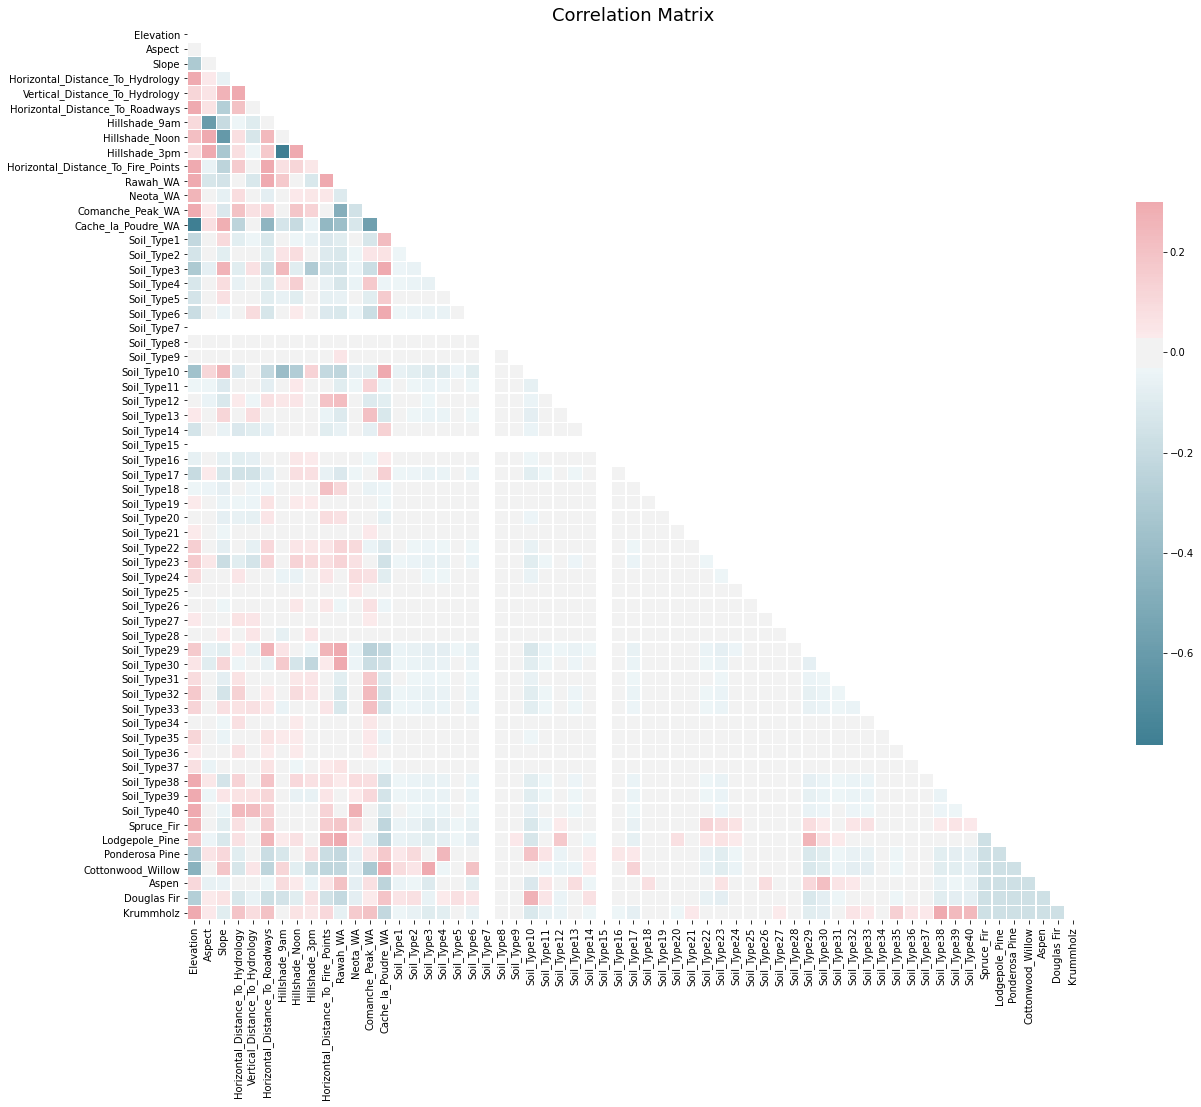

In [12]:
# Compute the correlation matrix 
#corr_data = train_df.copy()
corr = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax.set_title("Correlation Matrix", size = 18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


### Baseline Machine Learning Technique

Now that we have completed an assessment of our features, we will try a preliminary model to establish our baseline performance. The model we have selected to start with as our baseline is K-Nearest Neighbors. The KNN was selected as a starting model, not only because it is computationally the simplest model to start from, but also our features represent geographical position and therefore, agriculturally, it makes sense that a tree would be the same species as their physically nearby neighbor.

We then included our model in a pipeline to allow us to split the data set into training and validation sets, and to pass in multiple model parameters to be compared. Additionally, it has allowed us to incorporate 10 fold cross validation trials into our model evaluation process.  


In [13]:


def display_CrossValidation_class_level_charts(y_true, y_predict, label_classes):
# ################################################################################
# This function is implemented to display each class level Cross Validation chart
# y_true: Truth data given for lable
# y_predict:  Predicted labels from Machine learning models
# label_Classes: All the labels_class we are trying to predict
# #################################################################################
    fig = plt.figure(figsize=(14,12))
    plt.tight_layout()

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw = 2

    for i in range(len(label_classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        sp = fig.add_subplot(3, 3, i+1)
        sp.set_title('cover_class ' + str( label_classes[i]))
        plt.plot(fpr[i], tpr[i], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    plt.show() 


def ml_pipleline(ml_name, model, binarize = False,    detailedCVcharts = False):
# ##########################################################################################
# This pipeline funciton is define to centralize Machine Learning pipe line for this project
# ml_name - descriptive name, that can be used for printing
# moddel - Machine Learning Model object like KNN, Logistic or NB
# X_train: Training data
# y_train: label data from training
# X_validation:  Validation data
# y_valid: Label for validation data
# binarize: Some of the Machine Learning models requires binarization and some doesn't
# detailedCVcharts:  This to see details at each class level or not.
# ############################################################################################
# 70% train, 30% test
    lable_classes = classes=[1,2,3,4,5,6,7]

    y_binarized = label_binarize(y, lable_classes)
    
    if binarize:
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y_binarized, test_size=0.3, random_state=17)
        ml_pipe = Pipeline([('scaler', StandardScaler()), 
                           (ml_name, OneVsRestClassifier(model))]) 
    else:
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.3, random_state=17)
        ml_pipe = Pipeline([('scaler', StandardScaler()), 
                           (ml_name, model)]) 


    
    ml_pipe.fit(X_train, y_train)

    y_predict = ml_pipe.predict(X_valid)
    report = classification_report(y_predict, y_valid)
  
    print(color.BOLD, ml_name, color.END, '\n')
    print('Metrics: \n ', report)

    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
#     print('Cross Validation Scores:', cv_scores)
    print('\n Cross Validation Average Score', np.mean(cv_scores))
    

    if detailedCVcharts:
        display_CrossValidation_class_level_charts(y_valid, y_predict,lable_classes)
        
    return(report, y_predict)

In [19]:
?cross_val_score


Now we will apply our pipeline to assess the performance of an unweighted KNN model, with varying values of K. Each variation of K will output a performance overview with Precision, Recall, and F1 score and averaged Accuracy across all 10-fold cross validation trials.


In [14]:
# KNN Neighborhood with weights = uniform
knn_values = [1,3,5,7,9]
# knn_values = [3]
for value in knn_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=value)
    report, y_predict = ml_pipleline('KNN with '+ str(value) +'  Neighbors', knn_classifier, \
                                      binarize = False, detailedCVcharts = False )
                       

 KNN with 1  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.65      0.70      0.68       594
           2       0.60      0.69      0.64       567
           3       0.67      0.79      0.73       568
           4       0.94      0.87      0.90       702
           5       0.94      0.82      0.87       710
           6       0.79      0.72      0.75       698
           7       0.96      0.92      0.94       697

    accuracy                           0.79      4536
   macro avg       0.79      0.79      0.79      4536
weighted avg       0.80      0.79      0.80      4536


 Cross Validation Average Score 0.8343732093800371
 KNN with 3  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.65      0.67      0.66       613
           2       0.56      0.68      0.61       546
           3       0.67      0.79      0.73       563
           4       0.95      0.86      0.90       718
    

Interestingly we see that the best value of K based on our three-performance metrics is K=1. Normally we would anticipate seeing an increase in performance as the value of K increases.  Let us try weighting the distances and see if we can improve the results.

In [15]:
# KNN with weights = weighted distance (i.e. more weight is given for closer neighbor)
knn_values = [1,3,5,7,9]
# knn_values = [3]
for value in knn_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=value, weights='distance')
    report, y_predict = ml_pipleline('KNN with '+ str(value) +'  Neighbors', knn_classifier, \
                                      binarize = False, detailedCVcharts = False )

 KNN with 1  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.65      0.70      0.68       594
           2       0.60      0.69      0.64       567
           3       0.67      0.79      0.73       568
           4       0.94      0.87      0.90       702
           5       0.94      0.82      0.87       710
           6       0.79      0.72      0.75       698
           7       0.96      0.92      0.94       697

    accuracy                           0.79      4536
   macro avg       0.79      0.79      0.79      4536
weighted avg       0.80      0.79      0.80      4536


 Cross Validation Average Score 0.8343732093800371
 KNN with 3  Neighbors  

Metrics: 
                precision    recall  f1-score   support

           1       0.64      0.70      0.67       582
           2       0.58      0.70      0.63       541
           3       0.66      0.81      0.73       547
           4       0.95      0.86      0.90       722
    

Weighting the distances of our KNN does improve the performance of each model for each value of K > 1; however, we still see the best performance overall with K=1. Our speculation for this cause goes back to the large overlap of each features' distribution for the target classes. For example, we see representation of all target classes in the Elevation range 2500 to 3000 (shown again below); this would mean that as our model considers more and more neighbors, there is greater variation in the target classes being voted up by the neighbors. Thus, the more neighbors our model considers, the more like a random guess the prediction gets.

In [18]:
fig = px.histogram(train_df, x="Elevation", color="Cover_Type")
fig.show()

###**Summary**

To conclude our baseline, we have established an initial 1-NN model with avg. Accuracy of 83.4%. We selected accuracy as the performance metric to be evaluated for a few reasons. First, it is a easily interpretable metric to allow us to quickly compare our initial models. Additionally, for many of these KNN models with varying K values, we see may equal Precision, Recall, and F1-score, leaving accuracy as the only distinguishing metric between the model variations. Lastly, we do not know the applied context of our problem to know what metric would be most appropriate to evaluate. For example, if the application of our model is to evaluate fire risk based on the cover type of the area, i.e. the prediction of the cover type determines if the fire risk is 'safe' or 'not-safe'. In this case, we would be more concerned with optimizing model Precision, as our False Positives (predicting a 'safe' cover_type when it is a 'not-safe' cover_type) would carry a high risk.